# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# CNN-RNN Multilabeling
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

El objetivo de este notebook es realizar predicciones multilabel sobre patrones geométricos mediante CNN-RNN.

## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import torchvision.models as models
import math 
from torch.nn.utils.rnn import pack_padded_sequence
%matplotlib inline
import sys 
import cv2 
import pickle

from utils import KunischMetrics
from utils import KunischPruner
from utils import DataExplorer
from utils import KunischPlotter

## Configuración de dispositivo

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Selección de dataset y experimento

In [3]:
root_dir = '..'

DS_FLAGS = []
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'gausblur': [gausblur]
              # 'msblur': [msblur]
              # 'mtnblur': [mtnblur]
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1
GAUSBLUR_TIMES = 1

use_pos_weights = True
pos_weights_factor = 1
NUM_LABELS = 26
BATCH_SIZE = 124

TH_TRAIN = 0.5
TH_VAL = 0.5
TH_TEST = 0.5

USE_TRANSFER = False

# 0 es 3090, 1 y 2 son 2080
CUDA_ID = 0

SAVE = False
K = 4

In [4]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
         'gausblur': GAUSBLUR_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic', 'gausblur']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

Kfolds = {}

for i in range(0, K):
    print("Fold ", i)
    patterns_dir = os.path.join(root_dir, 'patterns', data_flags, str(i))
    labels_dir = os.path.join(root_dir, 'labels', data_flags, str(i))

    if not (os.path.isdir(patterns_dir) and os.path.isdir(labels_dir)):
        print(patterns_dir)
        print(labels_dir)
        raise FileNotFoundError("""
        No existen directorios de datos para el conjunto de flags seleccionado. 
        Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation.
        """)
        
    exp_name = f"{NUM_LABELS}L"
    weights_str = str(pos_weights_factor)
    weights_str = weights_str.replace('.','_')
    exp_name += f'_weighted_{weights_str}' if use_pos_weights else ''
    print(f"Nombre del experimento: {exp_name}")
     
    output_dir = os.path.join(root_dir, "outputs", "cnn-rnn", data_flags, exp_name, str(i))
    model_dir = os.path.join(root_dir, "models", "cnn-rnn", data_flags, str(i))
    model_path = os.path.join(model_dir, exp_name)
    
    path_co = os.path.join(patterns_dir, 'train', 'circular ornaments')
    path_lz = os.path.join(patterns_dir, 'train', 'lozenge')
    path_pc = os.path.join(patterns_dir, 'train', 'pictographics')
    path_ro = os.path.join(patterns_dir, 'train', 'rectangular ornaments')
    path_sl = os.path.join(patterns_dir, 'train', 'strokes and lines')
    path_to = os.path.join(patterns_dir, 'train', 'triangular ornaments')
    
    ex_co = os.listdir(path_co)[random.randint(0, 5)].split('.')[0]
    ex_co = os.path.join(path_co, ex_co)

    ex_lz = os.listdir(path_lz)[random.randint(0, 5)].split('.')[0]
    ex_lz = os.path.join(path_lz, ex_lz)

    ex_pc = os.listdir(path_pc)[random.randint(0, 5)].split('.')[0]
    ex_pc = os.path.join(path_pc, ex_pc)
    
    ex_ro = os.listdir(path_ro)[random.randint(0, 5)].split('.')[0]
    ex_ro = os.path.join(path_ro, ex_ro)

    ex_sl = os.listdir(path_sl)[random.randint(0, 5)].split('.')[0]
    ex_sl = os.path.join(path_sl, ex_sl)

    ex_to = os.listdir(path_to)[random.randint(0, 5)].split('.')[0]
    ex_to = os.path.join(path_to, ex_to)
    
    Kfolds[i] = {
        'patterns_dir': patterns_dir,
        'labels_dir': labels_dir,
        'output_dir': output_dir,
        'model_path': model_path,
        'ex_photos': [ex_co, ex_lz, ex_pc, ex_ro, ex_sl, ex_to]
    }
    
    print("--Pattern set encontrado en {}".format(patterns_dir))
    print("--Labels set encontrado en {}".format(labels_dir))
    print("")
    

    if SAVE:
        os.makedirs(output_dir, exist_ok = True)
        os.makedirs(model_dir, exist_ok = True)
        print(f"Los resultados se guardarán en: {output_dir}")
        print(f"Los modelos se guardarán en: {model_dir}")

Fold  0
Nombre del experimento: 26L_weighted_1
--Pattern set encontrado en ..\patterns\base\0
--Labels set encontrado en ..\labels\base\0

Fold  1
Nombre del experimento: 26L_weighted_1
--Pattern set encontrado en ..\patterns\base\1
--Labels set encontrado en ..\labels\base\1

Fold  2
Nombre del experimento: 26L_weighted_1
--Pattern set encontrado en ..\patterns\base\2
--Labels set encontrado en ..\labels\base\2

Fold  3
Nombre del experimento: 26L_weighted_1
--Pattern set encontrado en ..\patterns\base\3
--Labels set encontrado en ..\labels\base\3



## Funciones auxiliares

In [5]:
# Construct Data Loader
class KunischDataset(torch.utils.data.Dataset):
    
    def __init__(self, images_dir, labels_file, transform, top_labels):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.pruner = KunischPruner(len(top_labels))
        self.pruner.set_top_labels(top_labels)
        labels = pd.read_json(labels_file, orient='index')
        self.labels_frame = self.pruner.filter_df(labels)
        self.num_labels = len(top_labels)
        self.images_dir = images_dir
        self.labels_file = labels_file
        self.transform = transform
        self.flags = data_flags
        self.top_labels = top_labels
                                       
    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_id = self.labels_frame.iloc[idx].name + '.png'
        img_name = None
        for chapter in os.listdir(self.images_dir):
          if img_id in os.listdir(os.path.join(self.images_dir, chapter)):
            img_name = os.path.join(self.images_dir, chapter, img_id)
            break
        if img_name is None:
          raise Exception(f'No se encontró la imagen para {img_id}')
        image = Image.open(img_name)
        image = image.convert('RGB')
        image = self.transform(image)

        labels = self.labels_frame.iloc[idx].values
        labels = np.where(labels)[0].tolist()
        labels = list(map(int, labels))
        labels = [self.num_labels] + labels + [self.num_labels + 1] #start and end
        # [26 ... 0 ... ... 27]
        labels = [x + 1 for x in labels] # add 1 to all labels so 0 has no meaning
        # [27 ... 1 ... ... 28]
        length = len(labels) 
        for i in range(self.num_labels + 2 - length): #Pad the labels (There are num_labels unique labels)
            labels = labels + [0]
        # [27 ... 1 ... ... 28 0 0 0 ... 0]
        target = torch.Tensor(labels).long()
        
        sample = {'image': image, 'labels': target, 'lengths': length,
                  'paths': img_name}
        
        return sample
 

# Define Beam Search   
def beam_search(k, s, predicted, x, y, pred_sequence_list, prob_sequence_list):
  #Inputs Definitions:
  #k: Top labels to consider
  #s: current state
  #predicted: result of lstm (softmax)
  #x: current path of labels
  #y: current paht of probabilities 
  #prediction_paths: list of all label paths
  #probability_paths: list of all probability paths
    
    #si se predice end, terminar
    if predicted == NUM_LABELS + 2:
        #print(x)
        #print(y)
        pred_sequence_list.append(x)
        prob_sequence_list.append(y)
        #print("PREDICHO END")
    # caso contrario: calculo un nuevo estado
    else:
        inputs = decoder.embedding(predicted) 
        outputs, s = decoder.execute_lstm(inputs, s)
        scores = torch.softmax(outputs[0],dim=0)
        top_k_scores = scores.topk(k)[1].unsqueeze(0)
        top_k_probs = scores.topk(k)[0].unsqueeze(0)
        #print(top_k_scores)
        #print(top_k_probs)

        sequences = x.expand(k,len(x))
        prob_sequences = y.expand(k,len(x))
        #print(sequences)
        #print(top_k_scores[0][0].unsqueeze(0))
        #step =1
        
        # para cada top k, itero (bajo un nivel del arbol)
        for i in range(top_k_scores.size(1)):
            x = torch.cat((sequences[i], top_k_scores[0][i].unsqueeze(0) ))
            y = torch.cat((prob_sequences[i], top_k_probs[0][i].unsqueeze(0) ))
            
            #el nuevo predicho es el ultimo elemento de x 
            predicted = x[len(x)-1].unsqueeze(0)
            
             #si todavia no predigo ningun label aparte de start y end o si hay uno nuevo, itero
            if True: #  len(x) <= 7:
                if (x[len(x)-2]==NUM_LABELS + 1 and len(pred_sequence_list)<2) or predicted not in x[:-1]:
                    #print('This is predicted: ', x[:-1])
                    #print('This is x: ',x)
                    # itero de nuevo pero con este nuevo estado, este nuevo predicted,
                    # x e y, ..
                    beam_search(k,s,predicted,x,y,pred_sequence_list,prob_sequence_list)
            else:
                #print("This case")
                beam_search(k, s, NUM_LABELS + 2, x, y, pred_sequence_list, prob_sequence_list )

#Generate Sample Images with Captions
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize([227, 227], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image


#Define the CNN RNN architecture

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the Alexnet Architecture modifying where appropriate"""
        super(EncoderCNN, self).__init__()
        alex_net = models.alexnet(pretrained=True)
        alex_net.classifier._modules['6'] = nn.Linear(4096, embed_size)

        
        self.alex_net = alex_net
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        features = self.alex_net(images)
        features = features.reshape(features.size(0), -1)
        #print(np.shape(features))
        #print(features.size())
        features = self.bn(features)
        return features

class CoolEncoderCNN(nn.Module):
    def __init__(self, embed_size, weights_path):
        """Load the Alexnet Architecture modifying where appropriate"""
        super(CoolEncoderCNN, self).__init__()
        alex_net = models.alexnet(pretrained=True)
        alex_net.classifier._modules['6'] = nn.Linear(4096, embed_size)
        alex_net.load_state_dict(torch.load(weights_path))
        self.alex_net = alex_net
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        features = self.alex_net(images)
        features = features.reshape(features.size(0), -1)
        #print(np.shape(features))
        #print(features.size())
        features = self.bn(features)
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=11):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def execute_lstm(self, features, states=None):
        """Generate labels for given image """

        inputs = features.unsqueeze(1)
        for i in range(1):#self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)

        return outputs, states
    
    def embedding(self, features, states=None):
        """Embedd predicted label"""
        for i in range(1):#self.max_seg_length):
            inputs = self.embed(features)                       # inputs: (batch_size, embed_size)
        return inputs

## Experimentos

In [6]:
fold = Kfolds[0]
labels_dir = fold['labels_dir']
patterns_dir = fold['patterns_dir']
output_dir = fold['output_dir']
model_path = fold['model_path']
# Carga de top labels
train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')

if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle')):
    print(f"Creando top_labels para {NUM_LABELS} labels")
    top_labels = pruner.filter_labels(train_labels)
    pruner.set_top_labels(top_labels)

    save = input(f"Se creará un archivo nuevo para {len(top_labels)} labels. Desea continuar? (y/n)")
    if save == "y":
        with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'wb') as f:
            pickle.dump(top_labels, f)
        print("Top labels creado con éxito")

    else:
        raise Exception("No se logró cargar top_labels")

else: 
    print(f"Usando top_labels previamente generados para {NUM_LABELS} labels")
    with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'rb') as f:
        top_labels = pickle.load(f)

kunischTrainSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'train'),
                                 labels_file=os.path.join(labels_dir, 'augmented_train_df.json'),
                                 transform=transforms.Compose([transforms.Resize((227, 227)),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize(
                                                                   mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])]),
                                 top_labels=top_labels)

kunischTrainLoader = torch.utils.data.DataLoader(kunischTrainSet, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Validation
kunischValidationSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'val'),
                                      labels_file=os.path.join(labels_dir, 'val_df.json'),
                                      transform=transforms.Compose([transforms.Resize((227, 227)),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(
                                                                        mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])]),
                                      top_labels=top_labels)

kunischValidationLoader = torch.utils.data.DataLoader(kunischValidationSet, batch_size=BATCH_SIZE, shuffle=True,
                                                      num_workers=0)

# Test
kunischTestSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'test'),
                                labels_file=os.path.join(labels_dir, 'test_df.json'),
                                transform=transforms.Compose([transforms.Resize((227, 227)),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize(
                                                                  mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]),
                                top_labels=top_labels)

kunischTestLoader = torch.utils.data.DataLoader(kunischTestSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



Usando top_labels previamente generados para 26 labels


['<padding>', 'panel', 'horizontal', 'ornament', 'hatched', 'vertical', 'metopal', 'circle', 'filling', 'enclosing', 'lozenge', 'double', 'cross-hatched', 'triangle', 'concentric', 'dotted', 'outline', 'meander', 'solid', 'chain', 'bar', 'cross', 'line', 'dot', 'hook', 'swastika', 'floor', '<start>', '<end>']
Epoch [0/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 42.15440392872644
Epoch [1/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 23.806426033141122
Epoch [2/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 19.661006382533483
Epoch [3/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 18.94238087487599
Epoch [4/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 18.09425111800905
Epoch [5/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 18.612754

Epoch [68/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 11.000225006587922
Epoch [69/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 10.74497792077443
Epoch [70/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 10.94191148546007
Epoch [71/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 10.993853372240823
Epoch [72/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 10.888336181640625
Epoch [73/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 10.700134882851252
Epoch [74/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 10.922321380130828
Epoch [75/100], Embedded Size: 512, Hidden Size: 1024, Layers: 4, LR: 0.001, W: 2.2e-05, Avg Loss: 10.701144142756386
Epoch [76/100], Embedded Size: 512, Hidden Size: 1024, Lay

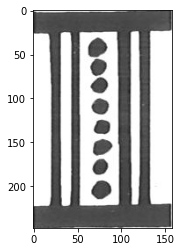

<start> circle filling <end>
Labels: [27  7  8 28] 
Prediction Path Probability: 0.0483

Working photo  ..\patterns\base\0\train\lozenge\36e
Calling to beam search
After beam search


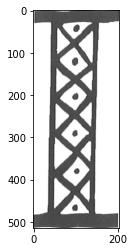

<start> circle filling <end>
Labels: [27  7  8 28] 
Prediction Path Probability: 0.0383

Working photo  ..\patterns\base\0\train\pictographics\90c
Calling to beam search
After beam search


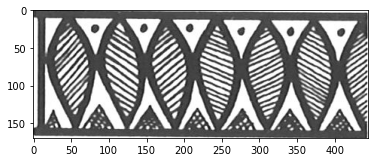

<start> circle filling <end>
Labels: [27  7  8 28] 
Prediction Path Probability: 0.0482

Working photo  ..\patterns\base\0\train\rectangular ornaments\11h
Calling to beam search
After beam search


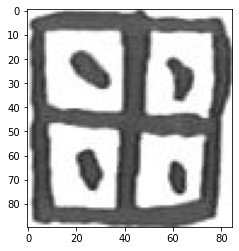

<start> circle filling <end>
Labels: [27  7  8 28] 
Prediction Path Probability: 0.0469

Working photo  ..\patterns\base\0\train\strokes and lines\10e
Calling to beam search
After beam search


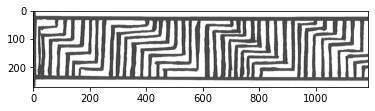

<start> panel horizontal <end>
Labels: [27  1  2 28] 
Prediction Path Probability: 0.0690

Working photo  ..\patterns\base\0\train\triangular ornaments\46i
Calling to beam search
After beam search


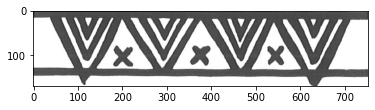

<start> circle filling <end>
Labels: [27  7  8 28] 
Prediction Path Probability: 0.0479



In [7]:
# Training the Model

fold = Kfolds[0]
labels_dir = fold['labels_dir']
patterns_dir = fold['patterns_dir']
output_dir = fold['output_dir']
model_path = fold['model_path']
photos = fold['ex_photos']

os.makedirs(model_path, exist_ok = True)
encoder_path = os.path.join(model_path, 'encoder.pth')
decoder_path = os.path.join(model_path, 'decoder.pth')


# Carga de top labels
train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')

vocab = list(top_labels.index.values)
vocab = ['<padding>'] + vocab + ['<start>', '<end>']
print(vocab)

embed_size = 512
hidden_size = 1024
num_layers = 4
# Build the models
if not USE_TRANSFER:
    encoder = EncoderCNN(embed_size).to(device)
else:
    encoder = CoolEncoderCNN(embed_size, os.path.join('..', 'models', 
    'alexnet', 'base', '0', '26L_weighted_1.pth')).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

learning_rate = 0.001
w = 2.20e-05

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.alex_net.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.RMSprop(params, lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=w)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=5, min_lr=0.0001)


num_epochs = 100

train_losses = []
for epoch in range(num_epochs):
    train_loss = 0
    encoder.train()
    decoder.train()
    for i, sample_batched in enumerate(kunischTrainLoader):
        
        # Set mini-batch dataset
        unsorted_images = sample_batched['image']
        unsorted_labels = sample_batched['labels']
        unsorted_lengths = sample_batched['lengths']
        #sorted_length_index = sorted(range(len(unsorted_lengths)),key=unsorted_lengths.__getitem__,reverse=True)
        #inputs =[]
        #labels = []
        #lengths = []
        #for j in sorted_length_index:
        #    inputs.append(unsorted_images[j])
        #    labels.append(unsorted_labels[j])
        #    lengths.append(unsorted_lengths[j])
        inputs = unsorted_images
        labels = unsorted_labels
        lengths = unsorted_lengths
        
        inputs =torch.stack(inputs).to(device)
        labels = torch.stack(labels).to(device)
        lengths = torch.stack(lengths)
        targets = pack_padded_sequence(labels , lengths, batch_first=True)[0].to(device)
        
        decoder.zero_grad()
        encoder.zero_grad()
        
        #print(labels)
        #print(targets)
        # Forward, backward and optimize
        features = encoder(inputs)
        outputs = decoder(features, labels , lengths)
        #print(outputs)
        #print(np.shape(outputs))
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss/len(kunischTrainLoader.dataset)*1024
    scheduler.step(train_loss)
    train_losses.append([epoch, train_loss ])
    
    print('Epoch [{}/{}], Embedded Size: {}, Hidden Size: {}, Layers: {}, LR: {}, W: {}, Avg Loss: {}'
          .format(epoch, num_epochs, embed_size, hidden_size,
                  num_layers, learning_rate, w, train_loss ))

    torch.save(encoder.state_dict(), encoder_path)
    torch.save(decoder.state_dict(), decoder_path)

print("Cargando modelos")
    
#Load Parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

print("Modelos cargados")

transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

for i in photos:
    print("Working photo ", i)
    img_name = i  +'.png'
    
    image = load_image(img_name, transform).to(device)
    encoder.eval()
    decoder.eval()
    prediction_paths = []
    probability_paths = []
    # Encode - read the image features
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    output_sample, s = decoder.execute_lstm(encoder_out)
    _, predicted = output_sample.max(1)  

    sequences = predicted
    prob_sequences = torch.sigmoid(output_sample.max())
    #display(sequences)
    #display(prob_sequences)
    
    print("Calling to beam search")
    beam_search(3, s, predicted, sequences, prob_sequences, prediction_paths, probability_paths)
    index_val = 0
    
    print("After beam search")
    for i in range(0, len(prediction_paths)):
        if i ==0:
            best = np.prod(probability_paths[i].detach().cpu().numpy())
        elif best < np.prod(probability_paths[i].detach().cpu().numpy()):
            best = np.prod(probability_paths[i].detach().cpu().numpy())
            index_val = i

    sampled_ids = prediction_paths[index_val].cpu().numpy()
    sampled_prob = best
    sampled_caption = []

    for word_id in sampled_ids:
        word = vocab[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    # Print out the image and the generated caption

    image = cv2.imread(img_name)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.show()
    print (sentence)
    print('Labels: {} \nPrediction Path Probability: {:.4f}'.format( sampled_ids,sampled_prob))
    print()


In [8]:
#Run Models on Test data using Beam Search

vocab = list(top_labels.index.values)
vocab = ['<padding>'] + vocab + ['<start>', '<end>']
print(vocab)

TP, TN, FP, FN = 0, 0, 0, 0
test_pred = []

images = []
im_labels = []
for sample in kunischTestLoader:
    images = images + sample['paths']
    lbl = sample['labels'].cpu().detach().numpy()
    for i in lbl:
        im_labels.append(i)
        
for i, j  in zip(images, im_labels):
    img_name = i
    labels = j
    labels = list(map(int, labels))
    try:
        labels.remove(NUM_LABELS + 1)
        labels.remove(NUM_LABELS + 2)
    except:
        print("Etiquetas no incorporan start, end")
    
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    encoder.eval()
    decoder.eval()
    
    # Prepare an image
    image = load_image(img_name, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    prediction_paths = []
    probability_paths = []
    # Encode - read the image features
    encoder_out = encoder(image_tensor)  # (1, enc_image_size, enc_image_size, encoder_dim)
    output_sample, s = decoder.execute_lstm(encoder_out)
    _, predicted = output_sample.max(1)  

    predicted = torch.tensor([NUM_LABELS + 1]).to(device)
    sequences = predicted
    prob_sequences = torch.sigmoid(output_sample.max())
    prob_sequences

    beam_search(4, s, predicted, sequences, prob_sequences,prediction_paths, probability_paths)
    for i in range(len(prediction_paths)):
        if i ==0:
            best = np.prod(probability_paths[i].detach().cpu().numpy())
            index_val = i 
        elif best < np.prod(probability_paths[i].detach().cpu().numpy()):
            best = np.prod(probability_paths[i].detach().cpu().numpy())
            index_val = i

    sampled_ids = prediction_paths[index_val].cpu().numpy()
    
    pred = sampled_ids
    
    
    end = np.argwhere(pred==NUM_LABELS + 2)[0][0]
    start = np.argwhere(pred==NUM_LABELS + 1)[0][0]+1
    pred = pred[start:end]
    
    pred2 = np.zeros(NUM_LABELS)
    labels2 = np.zeros(NUM_LABELS)
    for i in pred:
        pred2[i-1]=1
    for i in labels:
        labels2[i-1]=1   
    test_pred.append([img_name,labels2,pred2])
    TP += ((pred2==1)&(labels2==1)).sum()
    TN += ((pred2==0)&(labels2==0)).sum()
    FP += ((pred2==1)&(labels2==0)).sum()
    FN += ((pred2==0)&(labels2==1)).sum()

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = 2 * (precision*recall)/(precision+recall)
print(TP,TN,FP,FN)
print('Test: Accuracy: {:.4f}\tPrecision: {:.4f}\t Recall: {:.4f}\t F1 Score: {:.4f}\n'.
          format(accuracy,  precision, recall, f1_score))

['<padding>', 'panel', 'horizontal', 'ornament', 'hatched', 'vertical', 'metopal', 'circle', 'filling', 'enclosing', 'lozenge', 'double', 'cross-hatched', 'triangle', 'concentric', 'dotted', 'outline', 'meander', 'solid', 'chain', 'bar', 'cross', 'line', 'dot', 'hook', 'swastika', 'floor', '<start>', '<end>']
131 3949 257 707
Test: Accuracy: 0.8089	Precision: 0.3376	 Recall: 0.1563	 F1 Score: 0.2137



In [9]:
final_labels = []
final_preds = []
for elem in test_pred:
    final_preds.append(elem[2])
    final_labels.append(elem[1])

In [10]:
metrics = KunischMetrics(np.array(final_labels), np.array(final_preds))

In [11]:
recall = metrics.recall()
prec = metrics.precision()
acc = metrics.acc()
f1 = metrics.f1()
hs = metrics.hs()
emr = metrics.emr()
mr1 = metrics.mr1()
mr2 = metrics.mr2()
mr3 = metrics.mr3()


In [12]:
print("Recall", recall)
print("Precision", prec)
print("Accuracy", acc)
print("F1", f1)
print("HS", hs)
print("EMR", emr)
print("1MR", mr1)
print("2MR", mr2)

Recall 0.1563
Precision 0.3376
Accuracy 0.0
F1 0.2137
HS 0.1495
EMR 0.0
1MR 0.3866
2MR 0.2887
